![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps&file=Vertex+AI+Pipelines+-+Management.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Vertex%20AI%20Pipelines%20-%20Management.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FVertex%2520AI%2520Pipelines%2520-%2520Management.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Vertex%20AI%20Pipelines%20-%20Management.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Vertex%20AI%20Pipelines%20-%20Management.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

---
This is part a [series of notebook based workflows](./readme.md) that teach all the ways to use pipelines and experiments within Vertex AI. The suggested order and description/reason is:

||Notebook Workflow|Description|
|---|---|---|
||[Vertex AI Pipelines - Introduction](./Vertex%20AI%20Pipelines%20-%20Introduction.ipynb)|Introduction to pipelines with the console and Vertex AI SDK|
||[Vertex AI Pipelines - Components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb)|An introduction to all the ways to create pipeline components from your code|
||[Vertex AI Pipelines - IO](./Vertex%20AI%20Pipelines%20-%20IO.ipynb)|An overview of all the type of inputs and outputs for pipeline components|
||[Vertex AI Pipelines - Control](./Vertex%20AI%20Pipelines%20-%20Control.ipynb)|An overview of controlling the flow of exectution for pipelines|
||[Vertex AI Pipelines - Secret Manager](./Vertex%20AI%20Pipelines%20-%20Secret%20Manager.ipynb)|How to pass sensitive information to pipelines and components|
||[Vertex AI Pipelines - Scheduling](./Vertex%20AI%20Pipelines%20-%20Scheduling.ipynb)|How to schedule pipeline execution|
|_**This Notebook**_|[Vertex AI Pipelines - Management](./Vertex%20AI%20Pipelines%20-%20Management.ipynb)|Managing, Reusing, and Storing pipelines and components|
||[Vertex AI Experiments](./Vertex%20AI%20Experiments.ipynb)|Understanding and using Vertex AI Experiments|

To discover these notebooks as part of an introduction to MLOps [start here](./readme.md)!

---

# Vertex AI Pipelines - Management

Pipeliens are made up of steps which are execution of components.  These components are made up of code, container, and instruction (inputs and outputs).  Managing the artifacts for components and pipelines extends the MLOps practice with with source control.  This notebook based workflow focuses on ways to manage both **components** and **pipelines**.  Managing also enables easier sharing, versioning, and use - with Vertex AI even non-code users can leverage pipelines directly in the console as pipeline template.


---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.artifactregistry_v1', 'google-cloud-artifact-registry'),
    ('kfp', 'kfp')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

## API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable artifactregistry.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-management'
SERIES = 'mlops'

# gcs bucket
GCS_BUCKET = PROJECT_ID

Packages

In [47]:
import os
import yaml
import time
import importlib
from google.cloud import aiplatform
from google.cloud import artifactregistry_v1
import kfp
from typing import NamedTuple
from IPython.display import Markdown

Clients

In [9]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

# artifact registry client
ar_client = artifactregistry_v1.ArtifactRegistryClient()

parameters:

In [10]:
DIR = f"temp/{SERIES}-{EXPERIMENT}"

In [11]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [12]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Managing Components

Components are the building blocks of pipelines.  There are [multiple ways to construct components](./Vertex%20AI%20Pipelines%20-%20Components.ipynb) including using prebuilt components. For this example a simple lightweight Python component is constructed to show how the mechanics of managing a component. 

A key to keep in mind is that a component operates a remote function in a container.  This example uses a lightweight Python component and starts with a base image and code is added at runtime with the provided Python function.  Another type of function is a container component where the code is already built into the container.  

### Create Pipeline Components

These are simple Python components, specifically lightweight Python components.  These are the same ones used in the [introduction workflow](./Vertex%20AI%20Pipelines%20-%20Introduction.ipynb).

Simple component with multiple inputs of different data types and outputs a dictionary.

In [26]:
@kfp.dsl.component(
    base_image = "python:3.11",
    packages_to_install = ["pandas"]
)
def example_parameters(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    
    results = dict(
        ex_str = in_str,
        ex_int = in_int,
        ex_float = in_float,
        ex_bool = in_bool,
        ex_list = in_list
    )
    
    return results

Simple component that take input parameters and outputs an artifact.

In [27]:
@kfp.dsl.component(
    base_image = "python:3.10",
    packages_to_install = ["pandas"]
)
def example_artifact(
    metadata: dict
) -> kfp.dsl.Artifact:
    
    ex_artifact = kfp.dsl.Artifact(
        metadata = metadata,
        uri = 'https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#artifact-types'
    )
    
    return ex_artifact

### Compile Components

Just as pipelines can be compiled into YAML, so can components.  The following does this compilation for both components created above.
- [`kfp.compiler`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/compiler.html)

In [30]:
kfp.compiler.Compiler().compile(
    example_parameters,
    package_path = f'{DIR}/example_parameters.yaml'
)

kfp.compiler.Compiler().compile(
    example_artifact,
    package_path = f'{DIR}/example_artifact.yaml'
)

### Review Component YAML

The cell below print out the contents of one of the YAML files for a compiled component.  Note the following features:
- The `components` section has the details of the component including the input and output parameter names a data types
- The `deploymentSpec` has the container specified with:
    - `image` - the base image to use
    - `args` - the argument to run the specified function
    - `command` - in this case, a lightweight Python component, this has everything from the pip installs to the writing of the complete function to a file for execution

In [39]:
with open(f'{DIR}/example_parameters.yaml', 'r') as f:
    data = f.read()
Markdown(f"```yaml\n\n{data}\n```")

```yaml

# PIPELINE DEFINITION
# Name: example-parameters
# Inputs:
#    in_bool: bool
#    in_float: float
#    in_int: int
#    in_list: list
#    in_str: str
# Outputs:
#    Output: dict
components:
  comp-example-parameters:
    executorLabel: exec-example-parameters
    inputDefinitions:
      parameters:
        in_bool:
          parameterType: BOOLEAN
        in_float:
          parameterType: NUMBER_DOUBLE
        in_int:
          parameterType: NUMBER_INTEGER
        in_list:
          parameterType: LIST
        in_str:
          parameterType: STRING
    outputDefinitions:
      parameters:
        Output:
          parameterType: STRUCT
deploymentSpec:
  executors:
    exec-example-parameters:
      container:
        args:
        - --executor_input
        - '{{$}}'
        - --function_to_execute
        - example_parameters
        command:
        - sh
        - -c
        - "\nif ! [ -x \"$(command -v pip)\" ]; then\n    python3 -m ensurepip ||\
          \ python3 -m ensurepip --user || apt-get install python3-pip\nfi\n\nPIP_DISABLE_PIP_VERSION_CHECK=1\
          \ python3 -m pip install --quiet --no-warn-script-location 'kfp==2.7.0'\
          \ '--no-deps' 'typing-extensions>=3.7.4,<5; python_version<\"3.9\"'  &&\
          \  python3 -m pip install --quiet --no-warn-script-location 'pandas' &&\
          \ \"$0\" \"$@\"\n"
        - sh
        - -ec
        - 'program_path=$(mktemp -d)


          printf "%s" "$0" > "$program_path/ephemeral_component.py"

          _KFP_RUNTIME=true python3 -m kfp.dsl.executor_main                         --component_module_path                         "$program_path/ephemeral_component.py"                         "$@"

          '
        - "\nimport kfp\nfrom kfp import dsl\nfrom kfp.dsl import *\nfrom typing import\
          \ *\n\ndef example_parameters(\n    in_str: str,\n    in_int: int,\n   \
          \ in_float: float,\n    in_bool: bool,\n    in_list: list\n) -> dict:\n\
          \    results = dict(\n        ex_str = in_str,\n        ex_int = in_int,\n\
          \        ex_float = in_float,\n        ex_bool = in_bool,\n        ex_list\
          \ = in_list\n    )\n    return results\n\n"
        image: python:3.11
pipelineInfo:
  name: example-parameters
root:
  dag:
    outputs:
      parameters:
        Output:
          valueFromParameter:
            outputParameterKey: Output
            producerSubtask: example-parameters
    tasks:
      example-parameters:
        cachingOptions:
          enableCache: true
        componentRef:
          name: comp-example-parameters
        inputs:
          parameters:
            in_bool:
              componentInputParameter: in_bool
            in_float:
              componentInputParameter: in_float
            in_int:
              componentInputParameter: in_int
            in_list:
              componentInputParameter: in_list
            in_str:
              componentInputParameter: in_str
        taskInfo:
          name: example-parameters
  inputDefinitions:
    parameters:
      in_bool:
        parameterType: BOOLEAN
      in_float:
        parameterType: NUMBER_DOUBLE
      in_int:
        parameterType: NUMBER_INTEGER
      in_list:
        parameterType: LIST
      in_str:
        parameterType: STRING
  outputDefinitions:
    parameters:
      Output:
        parameterType: STRUCT
schemaVersion: 2.1.0
sdkVersion: kfp-2.7.0

```

In [41]:
#with open(f'{DIR}/example_artifact.yaml', 'r') as f:
#    data = f.read()
#Markdown(f"```yaml\n\n{data}\n```")

### Loading A Compiled Component

Managing (saving, reusing, and sharing) a compiled component file is completed by being able to load the component directly for future pipelines.  This is accomplished using the [`kfp.components`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/components.html) module which offers three functions for loading components compiled as YAML from either a file, a url or directly from a string:
- [`kfp.components.load_component_from_file`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/components.html#kfp.components.load_component_from_file)
- [`kfp.components.load_component_from_url`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/components.html#kfp.components.load_component_from_url)
- [`kfp.components.load_component_from_text`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/components.html#kfp.components.load_component_from_text)

The following cell load the `example_parameters` component from file and creates a new local component named `imported_example_parameters`.

In [42]:
imported_example_parameters = kfp.components.load_component_from_file(f'{DIR}/example_parameters.yaml')

In [44]:
type(imported_example_parameters)

kfp.dsl.yaml_component.YamlComponent

---
## Creating Pipelines

Pipelines are created from components and connecting them with inputs and outputs.  The section builds a pipeline from the components above, including the component imported from a compiled YAML file.  This follows the same pipeline as used in the [introduction workflow](./Vertex%20AI%20Pipelines%20-%20Introduction.ipynb).

### Create Pipeline

In [45]:
@kfp.dsl.pipeline(
    name = f'{SERIES}-{EXPERIMENT}',
    description = 'An introduction pipeline',
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root'
)
def intro_pipeline(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    
    task1 = imported_example_parameters(
        in_str = in_str,
        in_int = in_int,
        in_float = in_float,
        in_bool = in_bool,
        in_list = in_list
    )
    
    with kfp.dsl.If(in_bool == True, name = 'Proceed If True'):
        task2 = example_artifact(metadata = task1.output)

    return task1.output

### Compile Pipeline

Compile the pipeline to a local YAML file:
- [`kfp.compiler`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/compiler.html)

In [46]:
kfp.compiler.Compiler().compile(
    pipeline_func = intro_pipeline,
    package_path = f'{DIR}/{SERIES}-{EXPERIMENT}.yaml'
)

### Review Pipeline YAML

The cell below prints out the contents of one of the YAML files for a compiled pipeline.  Note the following features:
- The `components` section has the details of each component including the input and output parameter names a data types
- The `deploymentSpec` has the full specificaiton for each component

In [58]:
with open(f'{DIR}/{SERIES}-{EXPERIMENT}.yaml', 'r') as f:
    data = yaml.safe_load(f)
data.keys()

dict_keys(['components', 'defaultPipelineRoot', 'deploymentSpec', 'pipelineInfo', 'root', 'schemaVersion', 'sdkVersion'])

In [59]:
data['pipelineInfo']

{'description': 'An introduction pipeline',
 'name': 'mlops-pipeline-management'}

In [60]:
data['deploymentSpec']['executors'].keys()

dict_keys(['exec-example-artifact', 'exec-example-parameters'])

In [61]:
data['components'].keys()

dict_keys(['comp-condition-1', 'comp-example-artifact', 'comp-example-parameters'])

In [54]:
data['components']['comp-example-parameters']

{'executorLabel': 'exec-example-parameters',
 'inputDefinitions': {'parameters': {'in_bool': {'parameterType': 'BOOLEAN'},
   'in_float': {'parameterType': 'NUMBER_DOUBLE'},
   'in_int': {'parameterType': 'NUMBER_INTEGER'},
   'in_list': {'parameterType': 'LIST'},
   'in_str': {'parameterType': 'STRING'}}},
 'outputDefinitions': {'parameters': {'Output': {'parameterType': 'STRUCT'}}}}

### Create Pipeline Job (With Vertex AI SDK)

The compiled pipeline file can be submitted for running with the console or the SDK (shown here).  Check out the details in the documentation [here](https://cloud.google.com/vertex-ai/docs/pipelines/run-pipeline#create_a_pipeline_run) for an overview with the console.


In [62]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{SERIES}-{EXPERIMENT}",
    template_path = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    parameter_values = dict(
        in_str = 'An Example String',
        in_int = 45,
        in_float = 4.5,
        in_bool = True,
        in_list = [1, 27, 'Another String']
    ),
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    enable_caching = None # True (enabled), False (disable), None (defer to component level caching) 
)

### Submit Pipeline Job (On Vertex AI Pipelines)

In [63]:
response = pipeline_job.submit(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-management-20240518234230?project=1026793852137


In [64]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-management-20240518234230?project=1026793852137


In [65]:
pipeline_job.wait()

PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-management-20240518234230


### Retrieve A Pipeline Runs To A Dataframe:
- SDK Refrence: [`aiplatform.get_pipeline_df`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform#google_cloud_aiplatform_get_pipeline_df)

In [67]:
aiplatform.get_pipeline_df(pipeline = f'{SERIES}-{EXPERIMENT}')

,pipeline_name,run_name,param.input:in_bool,param.input:in_list,param.input:in_str,param.output:Output,param.input:in_int,param.vmlmd_lineage_integration,param.input:in_float
0,mlops-pipeline-management,mlops-pipeline-management-20240518234230,True,"[1.0, 27.0, Another String]",An Example String,"{'ex_bool': True, 'ex_float': 4.5, 'ex_str': '...",45.0,{'pipeline_run_component': {'parent_task_names...,4.5


---
## Manage Pipelines

The YAML file create above is a complete specification of a workflow with input paramters and a staging bucket.  This could be very useful to save, share, and reuse.  This section covers using Artifact Registry do this with a combination of:
- Kubeflow Pipelines SDK and the included [`kfp.registry.RegistryClient`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/registry.html)
- Google Cloud [Artifact Registry](https://cloud.google.com/artifact-registry/docs/overview) with native format for [Kubeflow pipeline templates](https://cloud.google.com/artifact-registry/docs/kfp)
- [Integration with Vertex AI](https://cloud.google.com/vertex-ai/docs/pipelines/create-pipeline-template#kubeflow-pipelines-sdk-client) for creating, uploading and using pipeline templates

### Setup Artifact Registry For KFP Repository

[Artifact registry](https://cloud.google.com/artifact-registry/docs) organizes artifacts with repositories.  Each repository contains packages and is designated to hold a partifcular format of package: Docker images, Python Packages and [others](https://cloud.google.com/artifact-registry/docs/supported-formats#package).  There is even a registry type specifically for [Kubeflow pipeline templates](https://cloud.google.com/artifact-registry/docs/kfp?hl=en) which is the focus in this notebooks workflow. It specifically stores and managed `kfp` pipelines files (compiled pipeliens are YAML files).

#### List All Repositories In Project/Region

This may be empty if no repositories have been created for this project

In [68]:
for repo in ar_client.list_repositories(parent = f'projects/{PROJECT_ID}/locations/{REGION}'):
    print(repo.name)

projects/statmike-mlops-349915/locations/us-central1/repositories/gcf-artifacts
projects/statmike-mlops-349915/locations/us-central1/repositories/mlops
projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915
projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915-docker
projects/statmike-mlops-349915/locations/us-central1/repositories/statmike-mlops-349915-python


#### Create/Retrieve KFP Repository

Create an Artifact Registry Repository to hold Docker Images created by this notebook.  First, check to see if it is already created by a previous run and retrieve it if it has.  Otherwise, create one named for this project.

In [69]:
try:
    kfp_repo = ar_client.get_repository(name = f'projects/{PROJECT_ID}/locations/{REGION}/repositories/{SERIES}')
except Exception:
    operation = ar_client.create_repository(
        parent = f'projects/{PROJECT_ID}/locations/{REGION}',
        repository_id = SERIES,
        repository = artifactregistry_v1.Repository(
            name = SERIES,
            format = artifactregistry_v1.Repository.Format.KFP
        )
    )
    kfp_repo = operation.result()

In [70]:
kfp_repo.name, kfp_repo.format_.name

('projects/statmike-mlops-349915/locations/us-central1/repositories/mlops',
 'KFP')

In [77]:
REPOSITORY = f"https://{REGION}-{kfp_repo.format_.name}.pkg.dev/{PROJECT_ID}/{kfp_repo.name.split('/')[-1]}"

In [78]:
REPOSITORY

'https://us-central1-KFP.pkg.dev/statmike-mlops-349915/mlops'

### Upload Pipeline To Registry

Loading the pipelines compiled YAML file can be done in several ways:
- Directly in the [Console For Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/create-pipeline-template#upload-the-template)
- With code using the KFP SDK [`kfp.registry`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/registry.html)

This section uses code to manage the upload.

#### Setup KFP Registry Client

In [83]:
import kfp.registry

In [93]:
token = !gcloud auth application-default print-access-token
kfp_registry = kfp.registry.RegistryClient(
    host = REPOSITORY,
    auth = kfp.registry.ApiAuth(token[0])
)

#### Upload YAML File To Registry

Like other repository types there are two types of references for artifacts: tags and version.  The versions are managed by the repository and the naming of versions is possible by supplying tags.  

In [90]:
template, version = kfp_registry.upload_pipeline(
    file_name = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    tags = ['v1', 'new'],
    extra_headers = dict(description = 'Example Pipeline Template', note = 'This is an example.')
)

In [91]:
template, version

('mlops-pipeline-management',
 'sha256:2f9c63a96aaa6e4fe5e48022688ffb44894a1bc5c84b9f329a8860178393573d')

### Review/Manage Repository

#### With KFP

The `kfp.registry` package can also be used to download the pipeline using the [`.download_pipeline()`](https://kubeflow-pipelines.readthedocs.io/en/latest/source/registry.html#kfp.registry.RegistryClient.download_pipeline) method which requires the name of the pipeline as either the version or a tag value.  The `file_name` parameter can be used to direct the naming of the download version.

In [100]:
kfp_registry.download_pipeline(
    package_name = template,
    #version = version,
    tag = 'v1',
    file_name = f'{DIR}/downloaded_pipeline.yaml'
)

'temp/mlops-pipeline-management/downloaded_pipeline.yaml'

#### From Vertex 

From the Console for Vertex AI you can directly view the pipeline in the repository and create runs of a pipeline version. 

**Path:** GCP Console > Vertex AI > Pipelines > Your Templates > Select Repository > Select The Repository > Select
<p><center>
    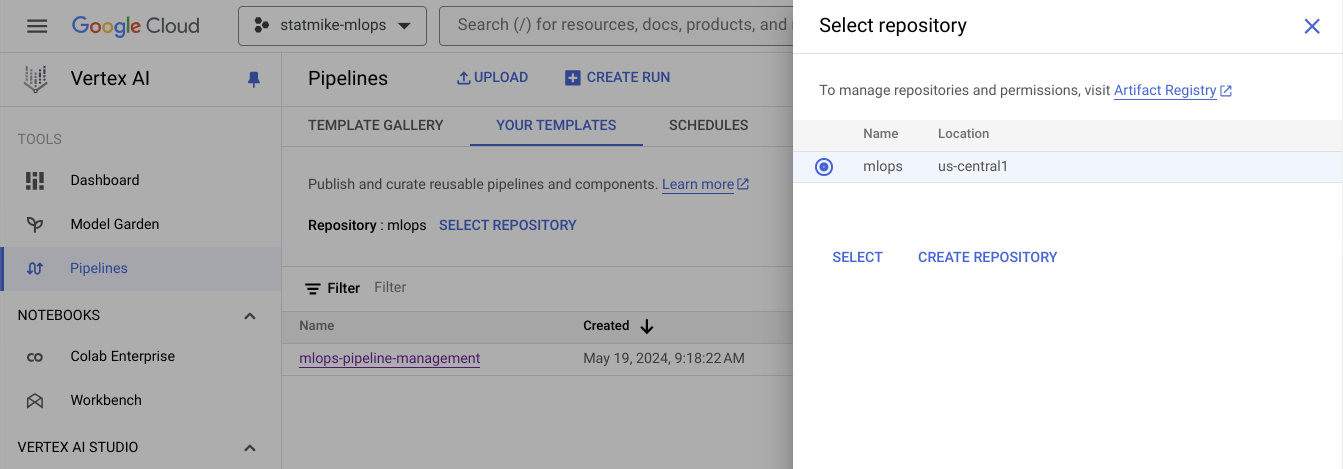
</center><p>

Then, Select The Template From the list
<p><center>
    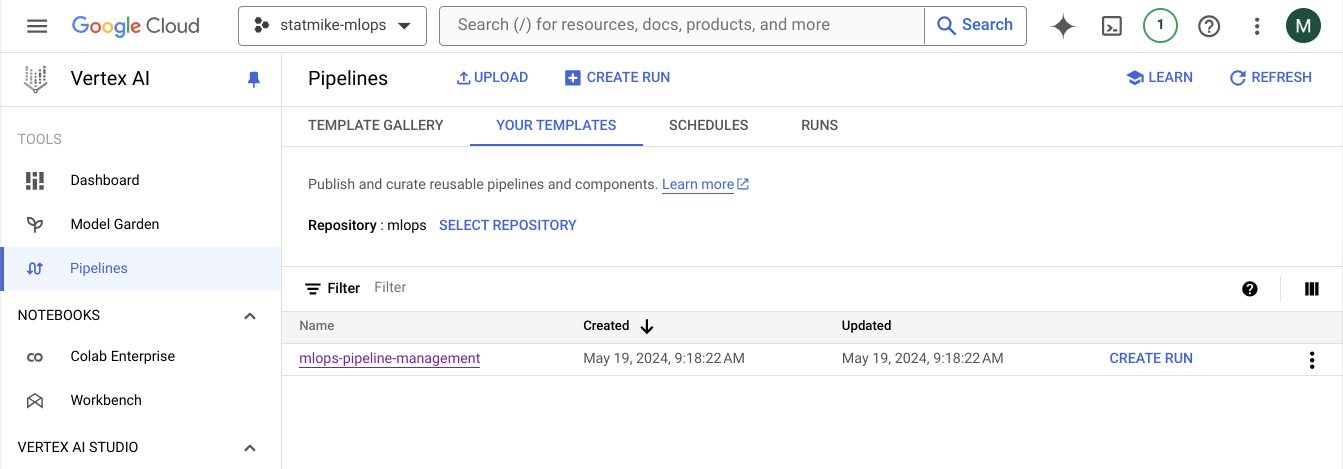
</center><p>  
   
Then, select a version or if their is only one version it goes straight to a view of the pipeline:
<p><center>
    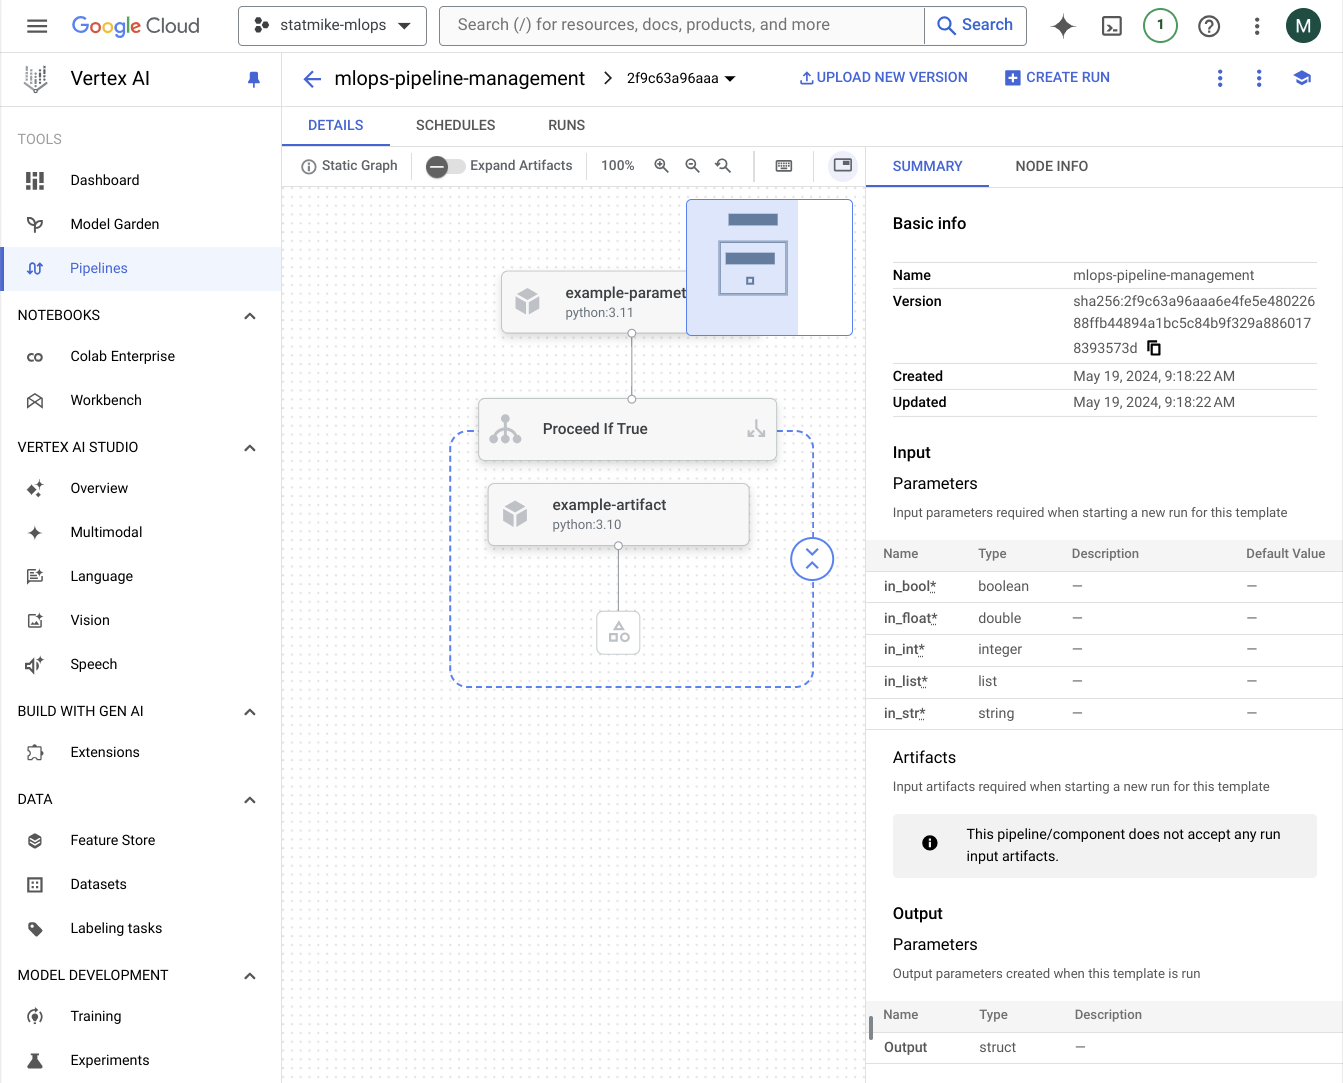
</center><p>
    
Console Users can even directly run the pipeline from the console by clicking "Create Run" and then the configuration menu comes up:
<p><center>
    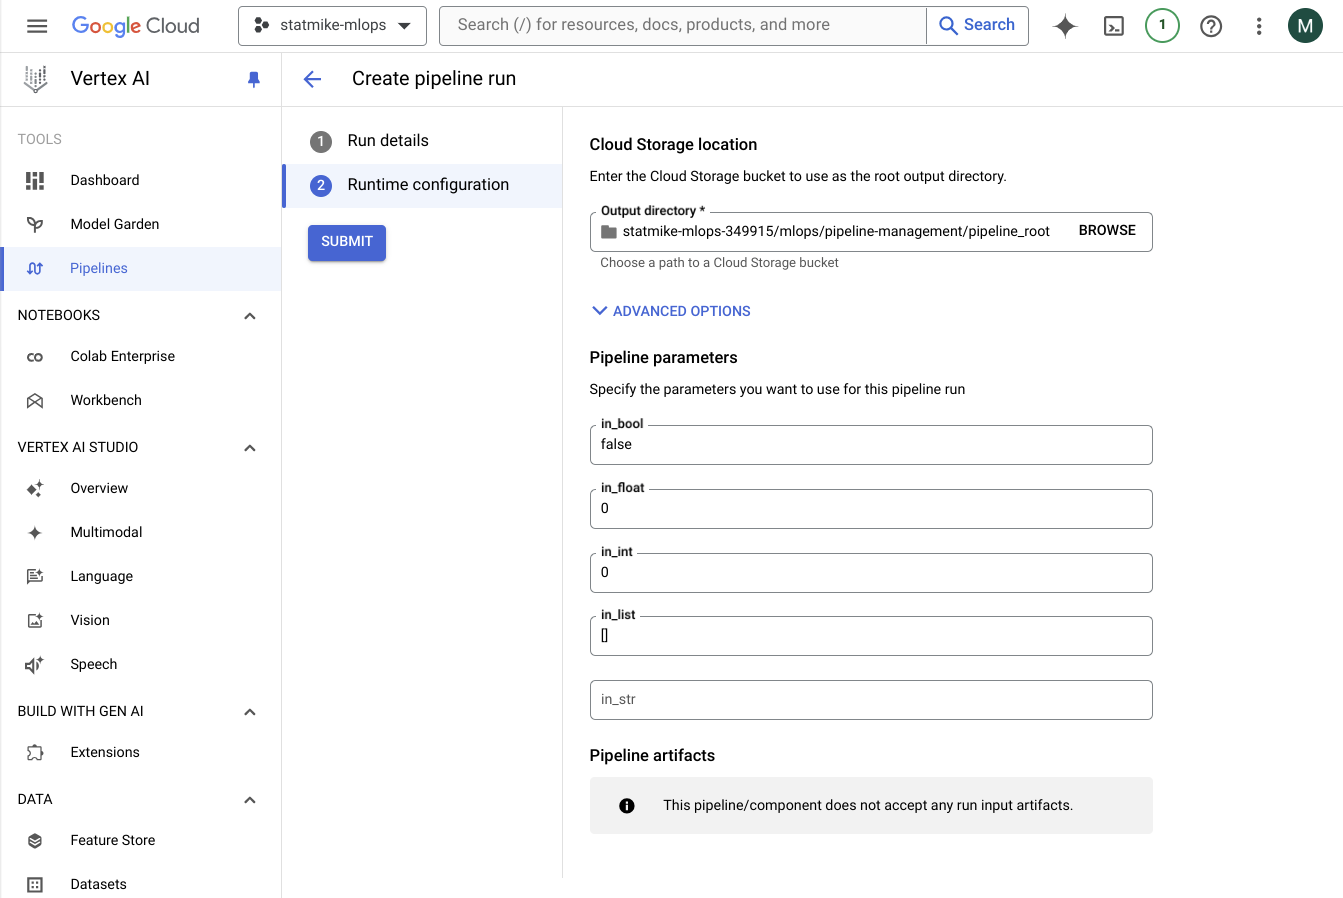
</center><p>
    
This allows the user to also specify the input parameters!

#### With Artifact Registry

### Pipeline Runs From The Repository

- load the pipleine to ar with KFP
- pipeline run from ar source: code, console
- see all runs
- filter to runs from ar source
- download for use locally with KFP sdk
- manage with AR client - list, get, version, tags